**Questions:**

* Why is my network worse than dde? Any improvements?

* How to use tensorboard?

* How to implement physics informed loss? Is it better to use pytorch for this?

* Weird text files?

* Warning in last cell?

In [323]:
import os
os.environ["DDE_BACKEND"] = "pytorch"  # Set backend to PyTorch before importing deepxde

In [324]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

In [325]:
# Define network class (we use the same base structure for both branch and trunk)
class Network(nn.Module):
    def __init__(self, input_dim, width, depth, output_dim):
        super(Network, self).__init__()
        
        self.depth = depth
        self.width = width
        
        # List that stores all layers
        self.hidden = nn.ModuleList()
        
        # Input layer
        self.input_layer = nn.Linear(input_dim, width)
        
        # Hidden layers 
        self.hidden = nn.ModuleList([nn.Linear(width, width) for i in range(depth)])
        
        # Output layers
        self.output_layer = nn.Linear(width, output_dim)
    
    def forward(self, x):
        # Define forward pass
        x = torch.relu(self.input_layer(x))
        for layer in self.hidden:
            x = torch.relu(layer(x))
        x = self.output_layer(x)
        return x


In [326]:
class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, branch_width, branch_depth, trunk_width, trunk_depth, output_dim):
        super(DeepONet, self).__init__()
        
        # Initialize branch and trunk networks
        self.branch = Network(branch_input_dim, branch_width, branch_depth, output_dim)
        self.trunk = Network(trunk_input_dim, trunk_width, trunk_depth, output_dim)
        
        # bias term
        self.bias = nn.Parameter(torch.zeros(1))

    
    def forward(self, input):
        # Forward pass through the networks
        branch_output = self.branch(input[0, :1])
        trunk_output = self.trunk(input[0, 1:])
        
        # Combine the outputs
        output = branch_output @ trunk_output + self.bias
        return output


In [327]:
# Set constants
q0, p0 = 1, 1
Tmin, Tmax = -2, 2
w_low, w_high = 1, 3

In [328]:
# Get analytical solution of the BVP for given t and omega
def analytic_solution(w, t, q0=q0, p0=p0):
    return q0*np.cos(w @ t.T) + p0*np.diag(1/w.flatten())@np.sin(w @ t.T)

# Returns a (len(w), len(t))-shape matrix

In [329]:
# Create training data
w_train = np.random.uniform(low=w_low, high=w_high, size=150).reshape(-1, 1)
t_train = np.random.uniform(low=Tmin, high=Tmax, size=100).reshape(-1, 1)
x, y = np.meshgrid(w_train, t_train)
X_train = np.vstack((x.ravel(), y.ravel())).T

y_train = analytic_solution(w_train, t_train).T.flatten().astype(np.float32)

tensor_x = torch.Tensor(X_train) # transform to torch tensor
tensor_y = torch.Tensor(y_train)

training_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
training_loader = DataLoader(training_dataset) # create your dataloader

In [330]:
# Create training data
w_test = np.random.uniform(low=w_low, high=w_high, size=150).reshape(-1, 1)
t_test = np.random.uniform(low=Tmin, high=Tmax, size=100).reshape(-1, 1)
x, y = np.meshgrid(w_test, t_test)
X_test = np.vstack((x.ravel(), y.ravel())).T

y_test = analytic_solution(w_test, t_test).T.flatten().astype(np.float32)

tensor_x = torch.Tensor(X_test) # transform to torch tensor
tensor_y = torch.Tensor(y_test)

testing_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
validation_loader = DataLoader(training_dataset) # create your dataloader

In [331]:
# Initialize the model
model = DeepONet(1, 1, 40, 2, 40, 2, 40)

# Example of setting up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [332]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [333]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 0.13268176461713774
  batch 2000 loss: 0.1301101463148085
  batch 3000 loss: 0.0887289398109155
  batch 4000 loss: 0.13711662023195406
  batch 5000 loss: 0.10624128703119545
  batch 6000 loss: 0.03385735737699112
  batch 7000 loss: 0.12229936140447553
  batch 8000 loss: 0.04473807072305689
  batch 9000 loss: 0.0722388797427615
  batch 10000 loss: 0.09667439914020694
  batch 11000 loss: 0.033945890612855564
  batch 12000 loss: 0.06366574607264004
  batch 13000 loss: 0.04054784630375225
  batch 14000 loss: 0.04226734741789683
  batch 15000 loss: 0.03312350387234636
LOSS train 0.03312350387234636 valid 0.1517864316701889
EPOCH 2:
  batch 1000 loss: 0.03459142867024846
  batch 2000 loss: 0.013578228531007552
  batch 3000 loss: 0.017060255797627433
  batch 4000 loss: 0.05572639472161688
  batch 5000 loss: 0.0255458610890894
  batch 6000 loss: 0.012708485140107428
  batch 7000 loss: 0.04370674736588847
  batch 8000 loss: 0.008524633049828338
  batch 9000 loss: 0.0

/var/folders/43/0xc7h8213cs2gpcym99hxdqm0000gn/T/ipykernel_69296/1771484180.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred = [model(torch.Tensor([[2, t]])).item() for t in t_vec]


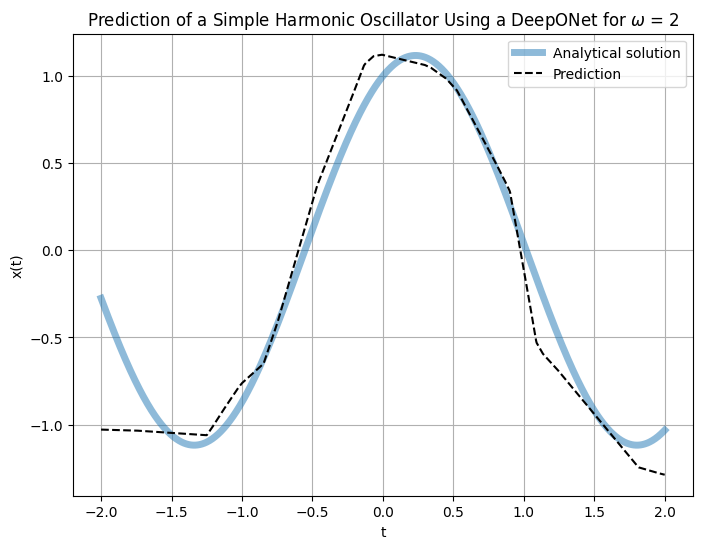

In [334]:
# Plot model prediction for one omega

# Get model prediction
w = np.array([2]).reshape(-1, 1)
t_vec = np.linspace(Tmin, Tmax, 1000).reshape(-1, 1)
pred = [model(torch.Tensor([[2, t]])).item() for t in t_vec]

# Get corresponding ground truth
ground_truth = analytic_solution(w, t_vec)

# Plot prediction vs. solution
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(t_vec.flatten(), ground_truth.flatten(), label='Analytical solution', alpha=0.5, linewidth=5)
ax.plot(t_vec.flatten(), pred, '--', label='Prediction', c='k')
ax.set_title('Prediction of a Simple Harmonic Oscillator Using a DeepONet for $\omega$ = 2')
ax.set_xlabel("t")
ax.set_ylabel("x(t)")
ax.legend()
ax.grid(True)
plt.show()